# Cliffworld: Dynamic Programming

The cliffworld is a 4 by 12 grid, where the bottom row consists of a "cliff" along with a start and a goal. We would like our agent to learn to get from start to goal without falling into the cliff. All transitions incur a living reward of -1, except for transitions out of the cliff which incur a cost of -100. The goal state is terminal and has no associated actions.

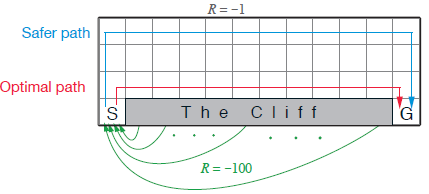

This problem is naturally represented as a MDP with each traversable cell as a state. Actions are left (<), right (>), up (^), and down (v); cliff states ('C') only have the action of teleporting to the start state. These are enumerated by the ```actions``` function . The cardinal direction actions are noisy; the agent moves in its intended direction with probability $p$ and in the two adjacent directions with probability $\frac12(1-p)$ each. When the agent moves into a wall, it stays in its original state. 

All of this information is in the ```Qvalue``` function below. A ```state``` is represented as a tuple of two indices that follow the same convention as a Numpy array; top left is (0,0), start is (3,0), and goal is (3,11). Given a ```state```, an ```action```, and a 2D numpy array of ```values```, the function computes the Q-value of taking ```action``` from ```state```, taking into account uncertainties, rewards, and successor state values. A discount factor ```gamma``` may also be applied.

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

def actions(state):
  if state == (3,11): return ['G']
  if state[0] == 3 and 0 < state[1] < 11: return ['C']
  return ['<', '>', '^', 'v']

def Qvalue(state, action, values, p, gamma):
  """
  Compute the Q-value for the given state-action pair,
  given a set of values for the problem, with successful transition
  probability p and discount factor gamma.
  """
  i,j = state
  gV = gamma*values
  pn = (1-p)/2

  # Handle goal and cliff states
  if action == 'G':
    return 0
  if action == 'C':
    return -100 + gV[(3,0)]

  # All possible successor states
  left = (i,max(j-1,0))
  right = (i,min(j+1,11))
  up = (max(i-1,0),j)
  down = (min(i+1,3),j)

  # Q-value computation
  if action == '<':
    return p*(-1+gV[left]) + pn*(-1+gV[up]) + pn*(-1+gV[down])
  elif action == '>':
    return p*(-1+gV[right]) + pn*(-1+gV[up]) + pn*(-1+gV[down])
  elif action == '^':
    return p*(-1+gV[up]) + pn*(-1+gV[left]) + pn*(-1+gV[right])
  else:
    return p*(-1+gV[down]) + pn*(-1+gV[left]) + pn*(-1+gV[right])

In [ ]:
def value_iteration(values, p, gamma, threshold=1e-6):
  """
  INPUTS: An initial 2D Numpy array of state values, p and gamma parameters, 
  and stopping threshold for value iteration
  OUTPUTS: Converged 2D Numpy array of state values
  """
  # YOUR CODE HERE
  #array of new values 
  newvalues = np.zeros_like(values)
  maxdiff = float('inf')
  while maxdiff>=threshold:
    for i in range(len(values)):
      for j in range(len(values[i])):
        #so now we're in the individual state values
        maxqvalue = -float('inf')
        state = (i, j)
        for action in actions(state):
          newqvalue = Qvalue(state, action, values, p, gamma)
          if newqvalue > maxqvalue:
            maxqvalue = newqvalue
        newvalues[i,j] = maxqvalue
    diff = np.abs(np.subtract(newvalues, values))
    maxdiff = np.amax(diff)
    values = np.copy(newvalues)
  return values


In [ ]:
def extract_policy(values, p, gamma):
  """
  INPUTS: A 2D Numpy array of state values, p and gamma parameters
  OUTPUTS: A 2D Numpy array of containing the policy (each cell should contain
  an action, one of the following: '<', '>', '^', 'v')
  """
  # YOUR CODE HERE
  #so we want to get the optimal values from value iteration
  #check the actions from those states, find best action, save in array 
  optimalvalues = value_iteration(values, p, gamma)
  policies = np.empty_like(values, dtype=object)
  for i in range(len(optimalvalues)):
    for j in range(len(optimalvalues[i])):
      state = (i,j)
      maxval = float('-inf')
      index = 0
      actionslist = actions(state)
      argmax = ""
      for action in actionslist:
        qval = Qvalue(state, action, optimalvalues, p, gamma)
        if qval > maxval:
          maxval = qval
          argmax = actionslist[index]
        index+=1
      policies[i,j] = argmax
  return policies

def cliffworld_valueiter(p, gamma):
  # Find and show the optimal values and policy for the given parameters
  values = value_iteration(np.zeros((4,12)), p, gamma)
  policy = extract_policy(values, p, gamma) 
  np.set_printoptions(linewidth=100)
  print(np.round(values,2),"\n")
  print(policy,"\n")

In [ ]:
p = 1
gamma = 1
cliffworld_valueiter(p, gamma)

In [ ]:
def evaluate_policy(policy, values, p, gamma, threshold=1e-6):
  """
  INPUTS: 2D Numpy arrays containing policy and initial state values, 
  p and gamma parameters, and stopping threshold for policy evaluation
  OUTPUTS: Converged 2D Numpy array of state values
  """
  # YOUR CODE HERE
  newvalues = np.zeros_like(values)
  maxdiff = float('inf')
  while maxdiff>=threshold:
    for i in range(len(values)):
      for j in range(len(values[i])):
        #so now we're in the individual state values
        state = (i, j)
        newqvalue = Qvalue(state, policy[i,j], values, p, gamma) 
        newvalues[i,j] = newqvalue
    diff = np.abs(np.subtract(newvalues, values))
    maxdiff = np.amax(diff)
    values = np.copy(newvalues)
  return values


def policy_iteration(policy, values, p, gamma):
  # Policy iteration wrapper function
  while True:
    values = evaluate_policy(policy, values, p, gamma)
    new_policy = extract_policy(values, p, gamma)
    if np.equal(new_policy, policy).all():
      return policy, values
    policy = new_policy

def cliffworld_policyiter(p, gamma):
  # Find and show the optimal values and policy for the given parameters
  init = extract_policy(np.zeros((4,12)), p, gamma)
  policy, values = policy_iteration(init, np.zeros((4,12)), p, gamma)
  np.set_printoptions(linewidth=100)
  print(np.round(values,2),"\n")
  print(policy,"\n")

In [ ]:
p = 1
gamma = 0.99
cliffworld_policyiter(p, gamma)

# Cliffworld: Reinforcement Learning

In [ ]:
import random

def epsilon_greedy_action(Qvalues, state, epsilon):
  # Explore a random action from state with probability epsilon
  # Otherwise, greedily choose the best action
  if random.random() < epsilon:
    return random.choice(actions(state))
  else:
    Qvalue = -float("inf")
    for a in actions(state):
      if Qvalues[(state, a)] > Qvalue:
        action = a
        Qvalue = Qvalues[(state, a)]
    return action  

def step(state, action, p):
  # Return successor state and reward upon taking action from state
  i,j = state
  if action == 'C':
    return (3,0), -100

  if action == '<':
    if random.random() < p: return (i,max(j-1,0)), -1
    else: return random.choice([(max(i-1,0),j), (min(i+1,3),j)]), -1
  if action == '>':
    if random.random() < p: return (i,min(j+1,11)), -1
    else: return random.choice([(max(i-1,0),j), (min(i+1,3),j)]), -1
  if action == '^':
    if random.random() < p: return (max(i-1,0),j), -1
    else: return random.choice([(i,max(j-1,0)), (i,min(j+1,11))]), -1
  else:
    if random.random() < p: return (min(i+1,3),j), -1
    else: return random.choice([(i,max(j-1,0)), (i,min(j+1,11))]), -1

In [ ]:
def SARSA(Qvalues, p, gamma, alpha, epsilon, episodes=50000):
  # SARSA temporal difference learning using initial Qvalues and given parameters
  # Returns a learned policy (Numpy 2d array)
  for i in range(episodes):
    state = (3,0)
    action = epsilon_greedy_action(Qvalues, state, epsilon)
    while state != (3,11):
      next_state, reward = step(state, action, p)
      next_action = epsilon_greedy_action(Qvalues, next_state, epsilon)
      target = Qvalues[(next_state, next_action)]
      Qvalues[(state, action)] += alpha * (reward + gamma*target - Qvalues[(state, action)])
      state = next_state
      action = next_action
  policy = extract_policy(Qvalues)
  return policy

def extract_policy(Qvalues):
  # Extract the optimal policy associated with the given Q-values
  policy = np.empty((4,12), dtype=object)
  for i in range(4):
    for j in range(12):
      policy[i,j] = epsilon_greedy_action(Qvalues, (i,j), 0)
  return policy

In [ ]:
def Qlearner(Qvalues, p, gamma, alpha, epsilon, episodes=50000):
  # Q-learning using initial Qvalues and given parameters
  # Returns a learned policy (2D Numpy array)  
  # YOUR CODE HERE
  for i in range(episodes):
    state = (3,0)
    action = epsilon_greedy_action(Qvalues, state, epsilon)
    while state != (3,11):
      next_state, reward = step(state, action, p)
      next_action = epsilon_greedy_action(Qvalues, next_state, epsilon)
      best_action = epsilon_greedy_action(Qvalues, next_state, 0)
      target = Qvalues[(next_state, best_action)]
      Qvalues[(state, action)] += alpha * (reward + gamma*target - Qvalues[(state, action)])
      state = next_state
      action = next_action
  policy = extract_policy(Qvalues)
  return policy


In [ ]:
def TD_learn(p, gamma, alpha, epsilon):
  Qvalues = {((i,j),a): 0 for i in range(4) for j in range(12) for a in actions((i,j))}
  policy = SARSA(Qvalues, p, gamma, alpha, epsilon)
  print("SARSA policy")   
  print(policy,"\n")
  
  Qvalues = {((i,j),a): 0 for i in range(4) for j in range(12) for a in actions((i,j))}
  policy = Qlearner(Qvalues, p, gamma, alpha, epsilon)
  print("Q-learning policy")  
  print(policy)

In [ ]:
p = 1
gamma = 1
alpha = 0.1
epsilon = 0.2
TD_learn(p, gamma, alpha, epsilon)

p = 0.8
gamma = 1
alpha = 0.1
epsilon = 0.2
TD_learn(p, gamma, alpha, epsilon)